Epoch 1/20, Loss: 0.10619514482289863
Epoch 2/20, Loss: 0.00032326589874476973
Epoch 3/20, Loss: 5.8833512957789937e-05
Epoch 4/20, Loss: 3.0599023163328334e-05
Epoch 5/20, Loss: 1.8865534563398494e-05
Epoch 6/20, Loss: 1.305650112044532e-05
Epoch 7/20, Loss: 9.870836076212678e-06
Epoch 8/20, Loss: 7.8282078978494e-06
Epoch 9/20, Loss: 6.276874872431411e-06
Epoch 10/20, Loss: 5.202352417654765e-06
Epoch 11/20, Loss: 4.586710364643901e-06
Epoch 12/20, Loss: 4.002899784912491e-06
Epoch 13/20, Loss: 3.6663330812795416e-06
Epoch 14/20, Loss: 3.18976738829709e-06
Epoch 15/20, Loss: 3.1284052624869218e-06
Epoch 16/20, Loss: 3.3975924414638334e-06
Epoch 17/20, Loss: 2.516816975154749e-06
Epoch 18/20, Loss: 3.0633589062745157e-06
Epoch 19/20, Loss: 2.3662108446842466e-06
Epoch 20/20, Loss: 2.0832102734402726e-06


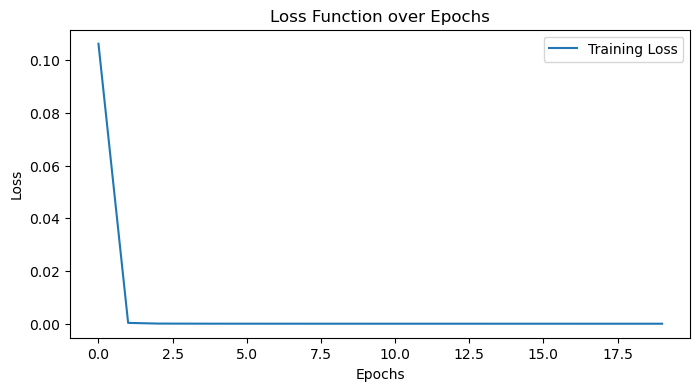

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Example synthetic dataset for demonstration
class EnergyDataset(Dataset):
    def __init__(self, data, n_input, n_output):
        self.X, self.y = self.prepare_data(data, n_input, n_output)
        
    def prepare_data(self, data, n_input, n_output):
        X, y = [], []
        for i in range(len(data) - n_input - n_output + 1):
            X.append(data[i:i + n_input])
            y.append(data[i + n_input:i + n_input + n_output])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN-LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self, n_input, n_features, n_output, lstm_units=100):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=(n_input // 2) * 32, hidden_size=lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, n_output)
        
    def forward(self, x):
        # CNN part
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        
        # Flatten the CNN output and prepare for LSTM
        batch_size = x.size(0)
        x = x.view(batch_size, 1, -1)
        
        # LSTM part
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last LSTM output
        
        # Fully connected output layer
        x = self.fc(x)
        return x

# Generate synthetic data for demonstration
data = np.sin(np.linspace(0, 100, 1000))  
n_input = 30  # Input sequence length
n_output = 14  # Prediction sequence length

# Create dataset and data loader
dataset = EnergyDataset(data, n_input, n_output)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model parameters
n_features = 1  # Number of features in the input
model = CNNLSTM(n_input, n_features, n_output)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Store losses for plotting
losses = []  # To store loss at each epoch

# Training the model
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X, y in data_loader:
        X = X.unsqueeze(1)  # Add channel dimension for Conv1D
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Average the loss for the epoch and store it
    epoch_loss /= len(data_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss}")

# Plot Loss Function over Epochs
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function over Epochs")
plt.legend()
plt.show()

# Test the model on new data
model.eval()

# Prepare the test input and actual values
test_input = torch.tensor(data[-n_input:], dtype=torch.float32).unsqueeze(0).unsqueeze(1)  # Prepare test input
actual_values = data[-n_output:]  # Actual values for comparison
prediction = model(test_input)

# Convert predictions to NumPy array (detaching from the computation graph)
predicted_values = prediction.detach().numpy().flatten()


